# 04 - Applied Machine Learning

In [1]:
import pandas as pd
import math
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#define the default figure size for this notebook
plt.figure(figsize=(20,10))
plt.rcParams['figure.figsize']=(10,10)
%matplotlib inline

## Table of Contents

<div class="lev1"><a href="#Question-1:-Propensity-score-matching">
<span class="toc-item-num">1&nbsp;&nbsp;</span>Propensity score matching</a></div>
 <div class="lev2"><a href="#1.0-Loading-the-data">
 <span class="toc-item-num">1.0&nbsp;&nbsp;</span>Loading the data</a></div>
 <div class="lev2"><a href="#1.1-A-naive-analysis">
 <span class="toc-item-num">1.1&nbsp;&nbsp;</span>A naive analysis</a></div>
 <div class="lev2"><a href="#1.2-A-closer-look-at-the-data">
 <span class="toc-item-num">1.2&nbsp;&nbsp;</span>A closer look at the data</a></div>
 <div class="lev2"><a href="#1.3-A-propensity-score-model">
 <span class="toc-item-num">1.3&nbsp;&nbsp;</span>A propensity score model</a></div>
 <div class="lev2"><a href="#1.4-Balancing-the-dataset-via-matching">
 <span class="toc-item-num">1.4&nbsp;&nbsp;</span>Balancing the dataset via matching</a></div>
 <div class="lev2"><a href="#1.5-Balancing-the-groups-further">
 <span class="toc-item-num">1.5&nbsp;&nbsp;</span>Balancing the groups further</a></div>
 <div class="lev2"><a href="#1.6-A-less-naive-analysis">
 <span class="toc-item-num">1.6&nbsp;&nbsp;</span>A less naive analysis</a></div>

 
<div class="lev1"><a href="#Question-2:-Applied-ML"><span class="toc-item-num">2&nbsp;&nbsp;</span>Applied ML</a></div>

instructions in black

<span style="color:#0047b3;"> Our answer in color

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.


#### 1.0 Loading the data

In [2]:
data = pd.read_csv('lalonde.csv', index_col=0)
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


#### 1.1 A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?



<span style="color:#0047b3;">We first count the number of people in each group: the treated group and the non-treated one

In [3]:
print("number of people treat : %d" % (data['treat'] == 1).sum())
print("number of people not treat : %d" % (data['treat'] == 0).sum())
print("number of people : %d" % data.shape[0])

number of people treat : 185
number of people not treat : 429
number of people : 614


<span style="color:#0047b3;">And we also have a look at the basic statistics :</span>

In [4]:
# this function makes a pretty print output of describe() 
def compare_feature(re0, re1):
    tmp = pd.DataFrame()
    tmp['non treated'] = re0.reset_index(drop=True)
    tmp['treated'] = re1.reset_index(drop=True)
    return (tmp.describe())

compare_feature(data.loc[data['treat'] == 0]['re78'],data.loc[data['treat'] == 1]['re78'])

,non treated,treated
count,429.000000,185.000000
mean,6984.169742,6349.143530
std,7294.161791,7867.402218
min,0.000000,0.000000
25%,220.181300,485.229800
50%,4975.505000,4232.309000
75%,11688.820000,9642.999000
max,25564.670000,60307.930000


<span style="color:#0047b3;">We now plot the boxplot:

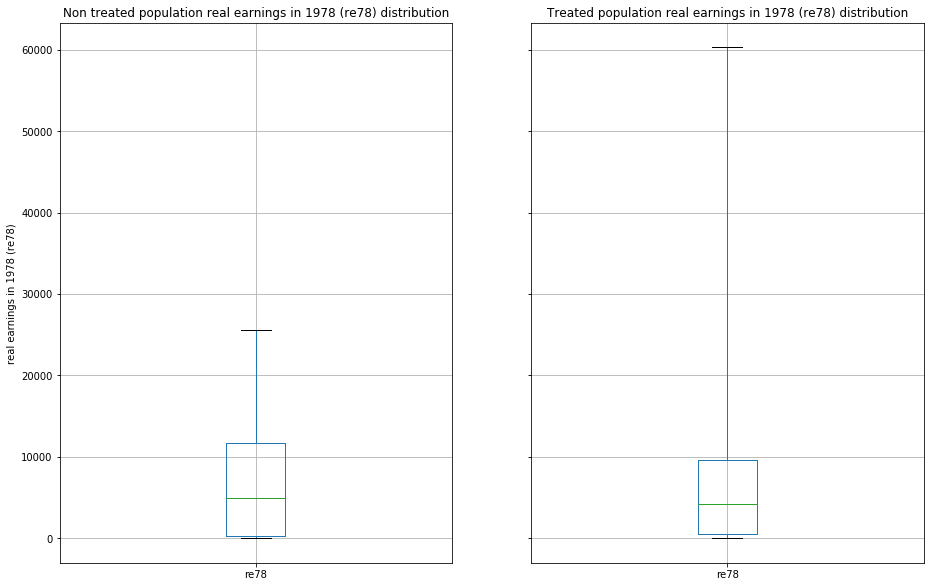

In [5]:
ax = data.groupby('treat').boxplot(figsize=(15,10), column='re78', whis=20)

ax[0].set_title('Non treated population real earnings in 1978 (re78) distribution')
ax[0].set_ylabel('real earnings in 1978 (re78)')
ax[1].set_title('Treated population real earnings in 1978 (re78) distribution');

<span style="color:#0047b3;">At first view, the non-treated group seems to earn more money than the treated group in 1978, that is after the treatment.<br><br>
Now, we will trace the distribution normalized by the number of people in each group: </span>

In [6]:
re78 = data[['treat', 're78']].copy()

# Compute the max earned money for each group
max3 = 27
max_t = int(re78.loc[re78['treat']==1].max().values[1])+1
max_nt = int(re78.loc[re78['treat']==0].max().values[1])+1

<div class="alert alert-warning">
This 'max3' parameter can be found by observing the result of the following line.

<br>=> Only 3 people earned more than 27k.
</div>

In [7]:
#Classify each row in slices of 1000 [money], with a last slice expending to the max.
re78['cat'] = pd.cut(re78.re78, [x*1000 for x in range(1, max3) ]+[max_t], include_lowest=False) 

x = re78.groupby(['cat','treat']).size().to_frame('occurences').reset_index()

x.loc[x['treat']==0,'occurences']/= x[x['treat']==0]['occurences'].sum() / 100
x.loc[x['treat']==1,'occurences']/= x[x['treat']==1]['occurences'].sum() / 100

In [8]:
#pick a seaborn colourblind-friendly colour palette
colorblind=['#0072B2','#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
sns.set_palette(colorblind)

<span style="color:#0047b3;">First, let's have a look at the proportion of people, in each group, having earned 0 money in re78.
<br>These are not included in the slice (0,1000], due to the *include_lowest=False* parameter, which allows a better visualisation of the following histogram.
</span>

In [9]:
#Compute the total number of occurences for each group.
totals = re78.drop(['cat'], axis=1).groupby('treat').count()

In [10]:
#Compute the ratio of occurences with 0 earned.
re78[re78.re78==0].drop(['cat'], axis=1).groupby('treat').count() / totals

,re78
treat,
0,0.228438
1,0.243243


/home/benjamin/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


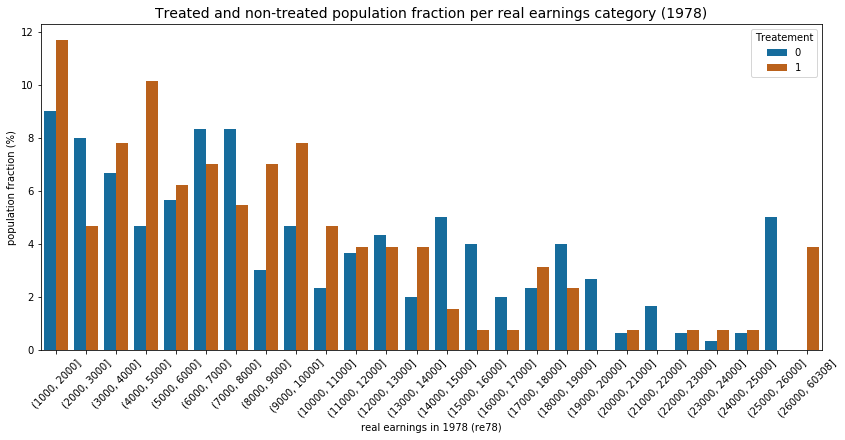

In [11]:
a4_dims = (14, 6)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)

ax = sns.barplot(ax=ax, x='cat', y='occurences', hue='treat', data=x)

ax.set_title('Treated and non-treated population fraction per real earnings category (1978)', fontsize=14)
ax.set(xlabel='real earnings in 1978 (re78)', ylabel='population fraction (%)')
ax.legend(loc='upper right', title='Treatement');

<span style="color:#0047b3;">The mean outcome in 1978 is higher for the non-treated group: this is explained in the distribution by the fact that in the non treated group, there is a non negligible number of people who earn between [24000, 25000] after the treatment, in 1978.<br><br>
Here we trace the distribution like above but we add the Kernel density estimation (KDE), which is an estimation of the continuous distribution.
Since the KDE is an aproximationso, it has false negative value, but it helps to easily compare distribution nonetheless.

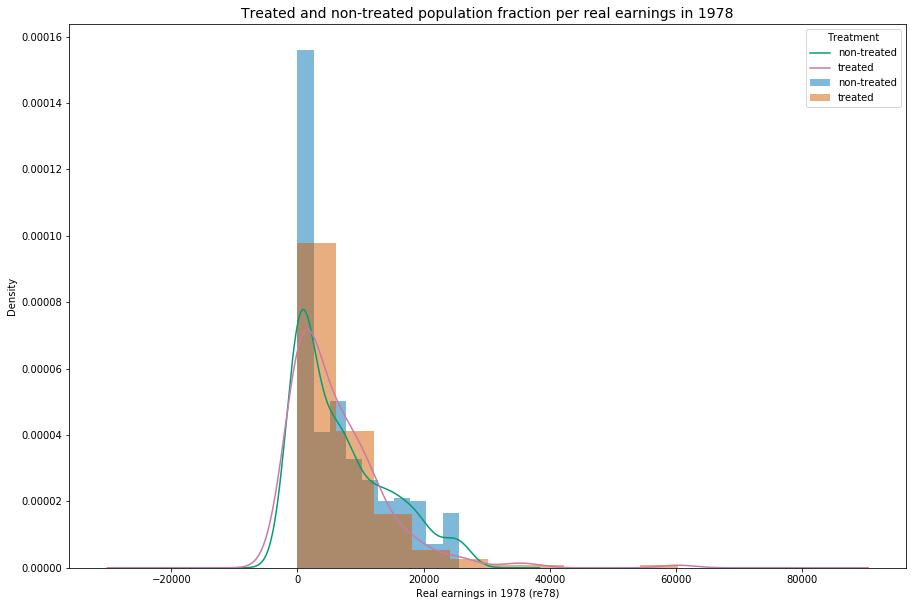

In [12]:
ax = data.groupby('treat')['re78'].plot.hist(figsize=(15,10),legend=True,normed=True,alpha=0.5)
ax[0].set_title('Treated and non-treated population fraction per real earnings in 1978', fontsize=14)
ax[0].set_xlabel('Real earnings in 1978 (re78)')

ax = data.groupby('treat')['re78'].plot.kde(figsize=(15,10),legend=True)
ax[0].legend(title='Treatment', labels=['non-treated', 'treated','non-treated', 'treated'], loc='upper right');

<span style="color:#0047b3;">**Naive Conclusion** : In the end, using graphics and numbers, a naive conlusion can be that non-treated people earn a little more money than treated people. Hence the treatment is not relevant.

#### 1.2 A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

<span style="color:#0047b3;">So now we will observe the distribution of each feature (except the `treat` feature):<br><br>
We first look at the distribution of the features using numbers, for both the treated group and the non-treated group:

In [17]:
data_treat = data.loc[data['treat'] == 1].drop('treat',axis=1)
data_notreat = data.loc[data['treat'] == 0].drop('treat',axis=1)
data_treat.describe()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [18]:
data_notreat.describe()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


<span style="color:#0047b3;"> Since it is hard to compare all those numbers, we will use histograms and Kernel Density Estimation (KDE) (recall it is just an estimation) :

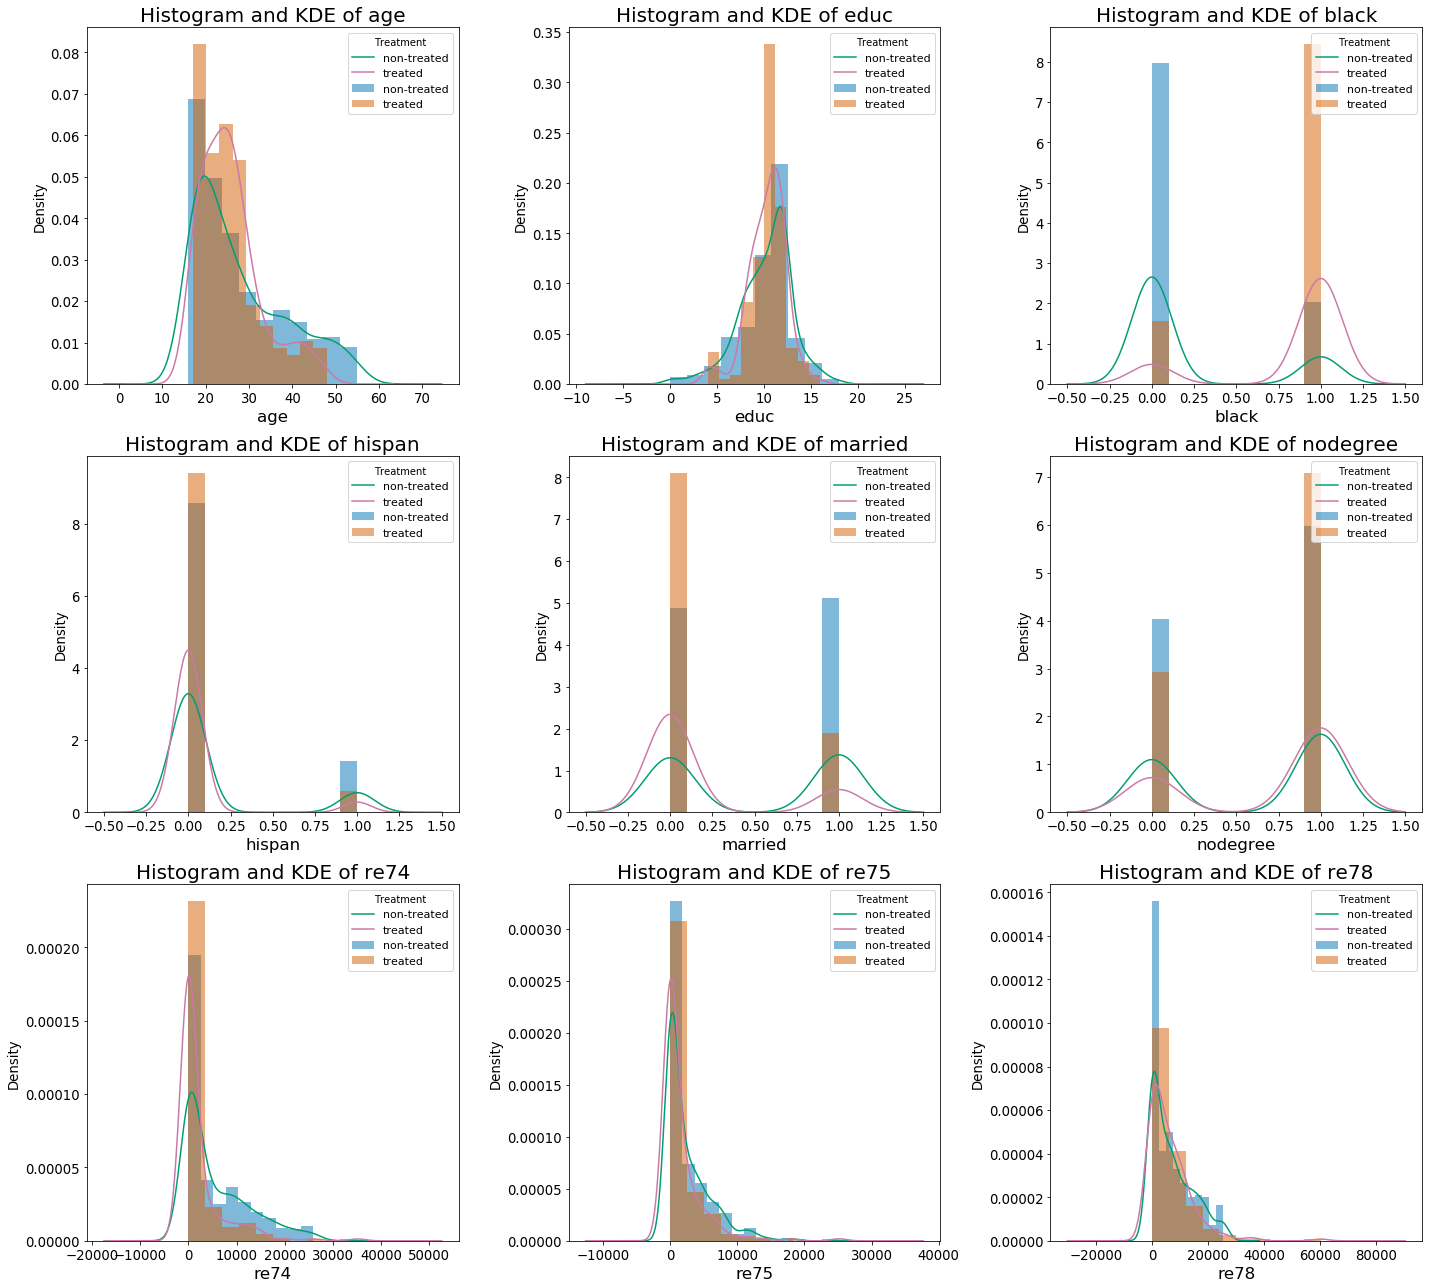

In [19]:
def density_hist_data(data, w=3, h=3):
    fig, axs = plt.subplots(h,w)
    i=0
    
    for c in data.columns:
        if c not in 'treat':
            # this plots a normed histrogram, so that the scale is the same as for KDE
            ax1, ax2 = data.groupby('treat')[c].plot.hist(ax=axs[math.floor(i/w), i%w], 
                                                          figsize=(60/w, h**2*2),
                                                          legend=True,
                                                          normed=True,
                                                          alpha=0.5)
            
            data.groupby('treat')[c].plot.kde(title="Histogram and KDE of "+c,
                                              fontsize=40/w,
                                              ax=ax1,
                                              figsize=(60/w, h**2*2),
                                              sharey=False,
                                              legend=True)
            ax1.title.set_size(60/w)
            ax1.set_ylabel('Density', size=40/w)
            ax1.set_xlabel(c, size=50/w)
            ax1.legend(title='Treatment', 
                       labels=['non-treated', 'treated', 'non-treated', 'treated'], 
                       loc='upper right', 
                       prop={'size': 33/w});
            i+=1        
    plt.tight_layout()
            
density_hist_data(data)

<span style="color:#0047b3;">
Now, we clearly see that some variable are not equaly distributed in the two groups, treated and non-treated:
    - medium variation : 
        - age
        - educ
        - hispan
        - re74
    - high variation :
        - black
        - married
<span style="color:#0047b3;">
So we can't compare directly the non-treated and the treated group, since they do not represent the same sample of population.

#### 1.3 A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

<span style="color:#0047b3;">In this section, we will use logistic regression to obtain a propability that a person participates in the study (i.e receives the treatment).
This way, two people having a similar propability means that their features are close. 

In [20]:
data_p = data.copy()
features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
X = data_p[features]

In [21]:
logistic = LogisticRegression()

# remove treat and re78 from the data and use treat as output
# We train a model on the 8 basic features to predict the column 'treat' [0,1]
logistic = logistic.fit(X, data['treat'])

# Save the prediction in a new column
data_p['p'] = logistic.predict_proba(X)[:,1] # Keep only the second value of the predict array, which is Proba('treat')

<span style="color:#0047b3;">We can have a look at the predictions for the first samples (all in the treated (=1) category)

In [22]:
logistic.predict(X.head(10))

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [23]:
precision = cross_val_score(logistic, data[data.columns[1:-1]], data['treat'], cv=20, scoring="precision")
recall = cross_val_score(logistic, data[data.columns[1:-1]], data['treat'], cv=20, scoring="recall")

print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Precision: 0.69 (+/- 0.43)
Recall: 0.71 (+/- 0.33)


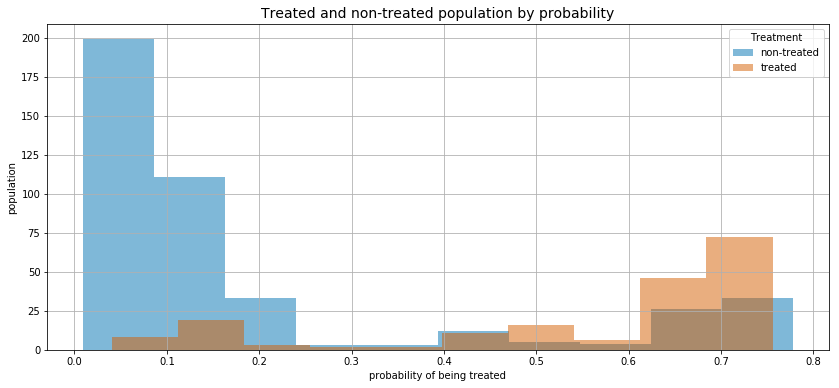

In [24]:
ax = data_p.groupby('treat')['p'].hist(figsize=(14,6), alpha=0.5)

ax[0].set_title('Treated and non-treated population by probability', fontsize=14)
ax[0].set_xlabel('probability of being treated')
ax[0].set_ylabel('population')
ax[0].legend(title='Treatment', labels=['non-treated', 'treated'], loc='upper right');

<span style="color:#0047b3;">This graph shows that a large fraction of people (highest blue peek) are not from the same population as the population of the treated people.<br><br>
Fortunately, there is a sample of the non-treated population (the second blue peek) which matches with the treated population. This is what we want, compare the groups for people who obtain the same proability score of being treated.
<br><br>Therefore, we can pair each treated people with a non-treated people.

#### 1.4 Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

<span style="color:#0047b3;">1.4.1 : </span>Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

<span style="color:#0047b3;">1.4.2 : </span>After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

<span style="color:#0047b3;">1.4.3 : </span>Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

<span style="color:#0047b3;">To sum up, here is the kind of matching (injective) we want to process :
<img src="inject.png">

<span style="color:#0047b3;">In order to match a treated person with a non-treated one, we will use `max_weight_matching` from the `networkx` package.
</span>

In [25]:
import networkx as nx
from networkx.algorithms import bipartite

def get_matching_pairs(df):
    """Match a treat and a not-treated peole using grah and networkx"""

    data_treat = df.loc[df['treat'] == 1] # separe group : treat
    data_notreat = df.loc[df['treat'] == 0] # not treat test group
    
    
    # Add nodes : One node from each group (bipartite)
    G = nx.Graph()
    G.add_nodes_from(data_notreat.index.values, bipartite=0) # Add the node attribute "bipartite"
    G.add_nodes_from(data_treat.index.values, bipartite=1)
    
    #   Treated         not Treated
    #     PT1                PNT1  
    #     PT2                PNT2
    #     ..                 ..
    #     PTN                PNTN
    #                          ..
    #                        PNTK 

    
    # Now we add edges (between any from treated -> any from non-treated node) with such weights :
    #  1.5 - abs(propensity Score treated - propensity Score not-treated )
    #
    # To use the max_weight_matching function, we need a high weight 
    # for edges between two nodes having the same propensity score. 
    # Hence we substract the difference from a max_weight parameter (1.5)
    #
    # i.e. The more difference there is, the less is the weight
    # and for high similarity, the weight is close to 1.5
  
    # Add edges with corresponding weight
    for i in range(len(data_treat.index.values)) :
            for i2 in range(len(data_notreat.index.values)) :
                index1=data_treat.index.values[i]
                index2=data_notreat.index.values[i2]
                G.add_edge(index1,index2,weight=1.5-(np.abs(data_treat['p'][index1]-data_notreat['p'][index2])))

    # Get the maximum weight matching :
    match = nx.max_weight_matching(G)

    # Compute the indices of the match in control group
    indices = []    
    s = 0
    for (key,value) in match.items():
        if key in data_treat.index.values :
            s += np.abs(data_treat['p'][key]-data_notreat['p'][value])
            '''print(key," ",
                  #value,data_treat['p'][key],
                  #data_notreat['p'][value],
                  np.abs(data_treat['p'][key]-data_notreat['p'][value]))'''
            indices.append(value)
    
    return s, data_notreat.loc[indices]

In [26]:
data_to_match = data_p.copy()

t_group = data_to_match.loc[data_to_match['treat'] == 1]
score, nt_group = get_matching_pairs(data_to_match) # get the matching in not-treated

matching_size = nt_group.shape[0]
print("Matching score :", score)
print('Mean score : ', round(score/matching_size,3))
data_matched = pd.concat([t_group, nt_group])

Matching score : 35.4132919444
Mean score :  0.191


<span style="color:#0047b3;">Where the score is a 'distance' defined by : $$ score = \sum\limits_{i,j = matching\ pair} \lvert i_{propensity} - j_{propensity} \lvert$$

<span style="color:#0047b3;">
**1.4.2** : <br>Let's have a look at the `re78` feature (real earnings in 1978, after the treatment):</span>

In [27]:
compare_feature(nt_group['re78'],t_group['re78'])

,non treated,treated
count,185.000000,185.000000
mean,5312.474907,6349.143530
std,5842.884861,7867.402218
min,0.000000,0.000000
25%,0.000000,485.229800
50%,3392.860000,4232.309000
75%,7933.914000,9642.999000
max,20243.380000,60307.930000


<span style="color:#0047b3;"> Our algorithm matched 25% of people who do not have a salary; that was not there in the treat group:
Maybe the treatment prevents from unemployment.</span>

<span style="color:#0047b3;">And we observe a big improvement : </span>

In [28]:
print("Improvement of "+str(round((t_group.re78.mean()-nt_group.re78.mean())/nt_group.re78.mean()*100,3))+" % for the mean")
print("Improvement of "+str(round((t_group.re78.median()-nt_group.re78.median())/nt_group.re78.median()*100,3))+" % for the median")

Improvement of 19.514 % for the mean
Improvement of 24.742 % for the median


<span style="color:#0047b3;">
**1.4.3** : <br>For comparing the effect of features on both groups, we plot 9 different graphs, one per feature:</span>

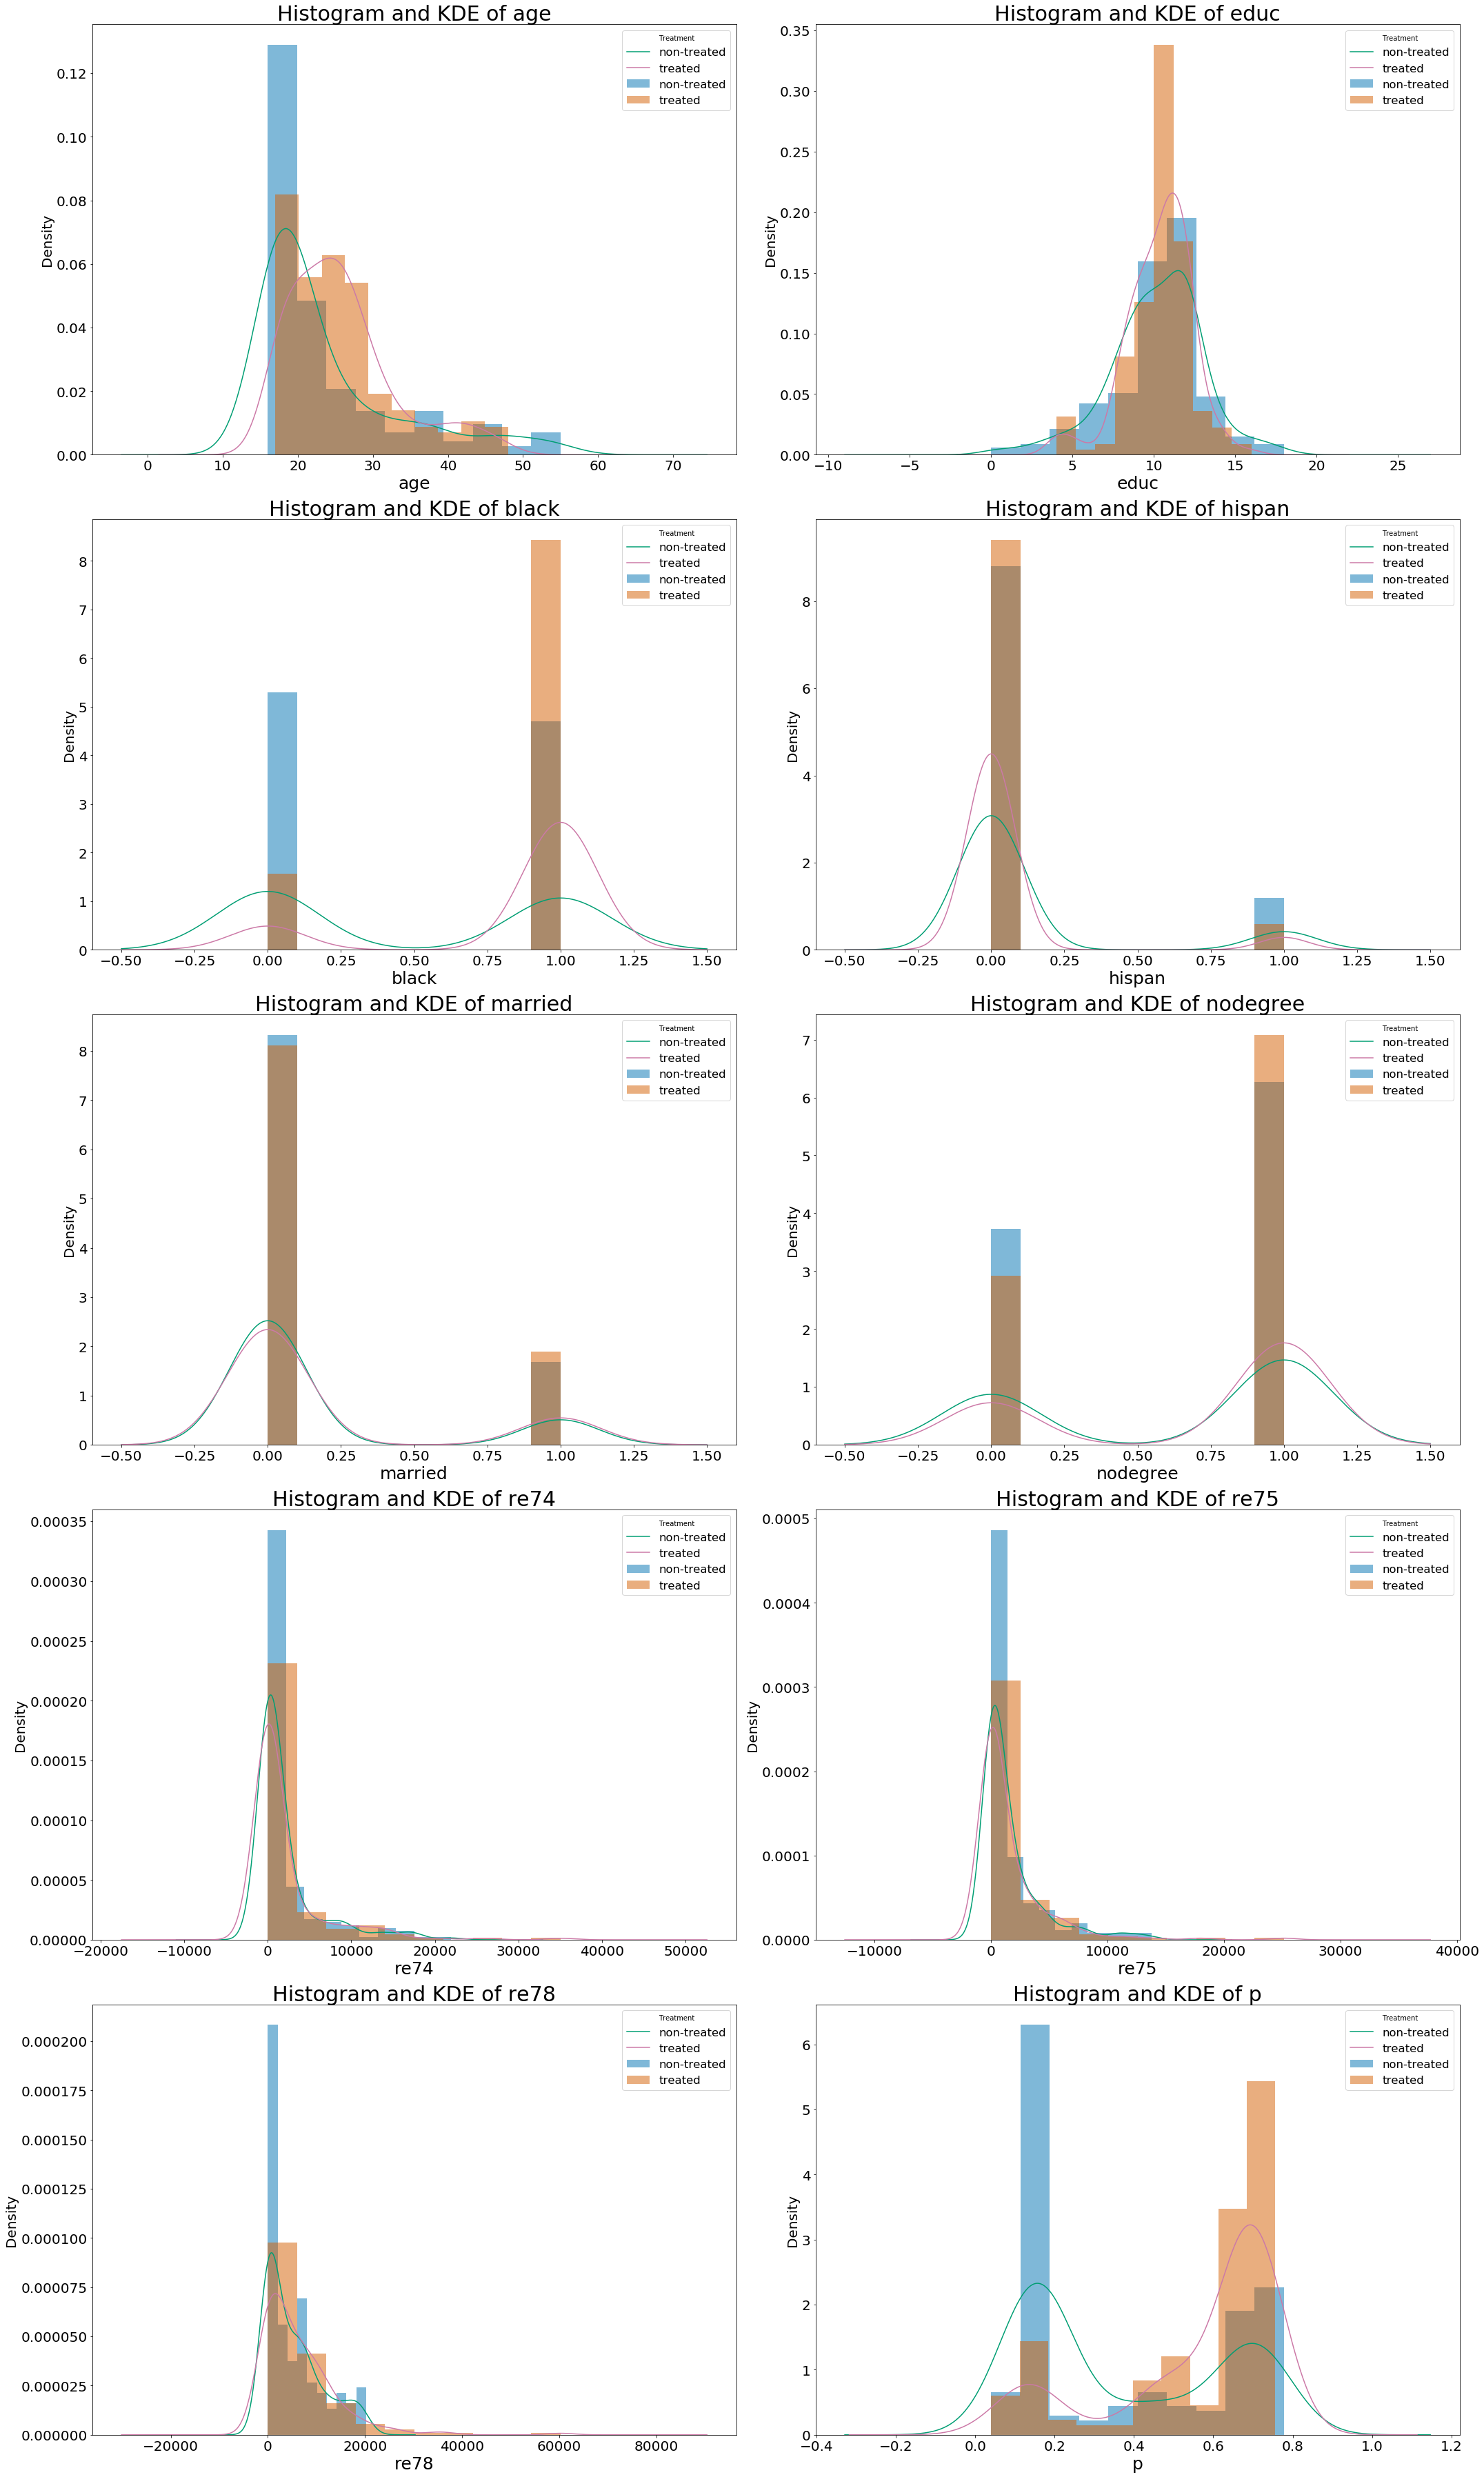

In [29]:
density_hist_data(data_matched, 2, 5)

<span style="color:#0047b3;"> 
Now we see that features are more balanced between the two groups.<br><br>
However, the proportaion of black (*black*) is not well balenced !!<br><br>
We therefore analyse these features:</span>

In [30]:
compare_feature(nt_group['black'], t_group['black'])

,non treated,treated
count,185.00000,185.000000
mean,0.47027,0.843243
std,0.50047,0.364558
min,0.00000,0.000000
25%,0.00000,1.000000
50%,0.00000,1.000000
75%,1.00000,1.000000
max,1.00000,1.000000


<span style="color:#0047b3;">So it would seem that the feature `black` is definitely not well balanced at all. It is the opposite in the treated group .<span style="color:#0047b3;">

<span style="color:#0047b3;">**Conclusion :** By comparing the salary of 1978 in this matching only, we obtain the contrary conclusion of 1.1, hence the mean salary of the treated group is higher than for the control group.</span>

#### 1.5 Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

<span style="color:#0047b3;">
As we discussed in 1.4, there is still a high disproportion of black people between the treated group and the control group after the matching. <br>So now we want to balance the `black` feature in order to get a more accurate study.</span>

<span style="color:#0047b3;">For this, we will only get people that have the same value of `black`:</span> 

In [31]:
def get_matching_pairs_add_feature(df, force_of_black=2.0/1.0):
    
    data_treat = df.loc[data['treat'] == 1]
    data_notreat = df.loc[data['treat'] == 0]
    
    # Add nodes : One node from each group (bipartite)
    G = nx.Graph()
    G.add_nodes_from(data_notreat.index.values, bipartite=0) # Add the node attribute "bipartite"
    G.add_nodes_from(data_treat.index.values, bipartite=1)
    
    # Same as above except that we take the black features in account in the weight
    for i in range(len(data_treat.index.values)) :
            for i2 in range(len(data_notreat.index.values)) :
                index1=data_treat.index.values[i]
                index2=data_notreat.index.values[i2]
                w1 = np.abs(data_treat['p'][index1]-data_notreat['p'][index2])
                w2 = np.abs(data_treat['black'][index1]-data_notreat['black'][index2])
                
                G.add_edge(index1, index2, weight = 3.5 - 1.0*w1 - force_of_black*w2)
    
    # Get the maximum weight matching :
    match = nx.max_weight_matching(G)

    # Compute the indices of the match in both groups
    indices_notreat = []    
    indices_treat = []    
    for (key,value) in match.items():
        if key in data_treat.index.values :
            # We retain the matching only if black feature is the same in both group
            if data_treat['black'][key]==data_notreat['black'][value] :
                
            #print(key," ",value,data_treat['p'][key],data_notreat['p'][value],np.abs(data_treat['p'][key]-data_notreat['p'][value]))
                indices_notreat.append(value)
                indices_treat.append(key)
    
    return data_notreat.loc[indices_notreat], data_treat.loc[indices_treat]

In [32]:
data_to_match = data_p.copy()

data_notreat, data_treat = get_matching_pairs_add_feature(data_to_match)

score = np.abs(data_treat['p'].values-data_notreat['p'].values).sum()
matching_size = data_notreat.shape[0]
print("Matching score :", score)
print('Mean score : ', round(score/matching_size, 3))

data_matched_2 = pd.concat([data_treat,data_notreat])

Matching score : 2.97437871618
Mean score :  0.026


<span style="color:#0047b3;">Where the scoring function is the same as defined in section 1.4<br>
Here we recapitulate the results of the two matchings :<br>

| Experiment | Size of matching | Score     | Mean score |
| :----------| :---------------:|:---------:| :---------:|
| **Simple matching**   | 185   | 35.41     | 0.191      |
| **Improved matching** | 116   | 2.83      | 0.024      |


<div class="alert alert-info">
NB : The perfect matching score based on the propensity score should be 0.
</div>

<span style="color:#0047b3;">Since we retained only the pairs with `black` feature being similar, we obtain a better balancing in these two features. However, we now have less people in the study.</span>

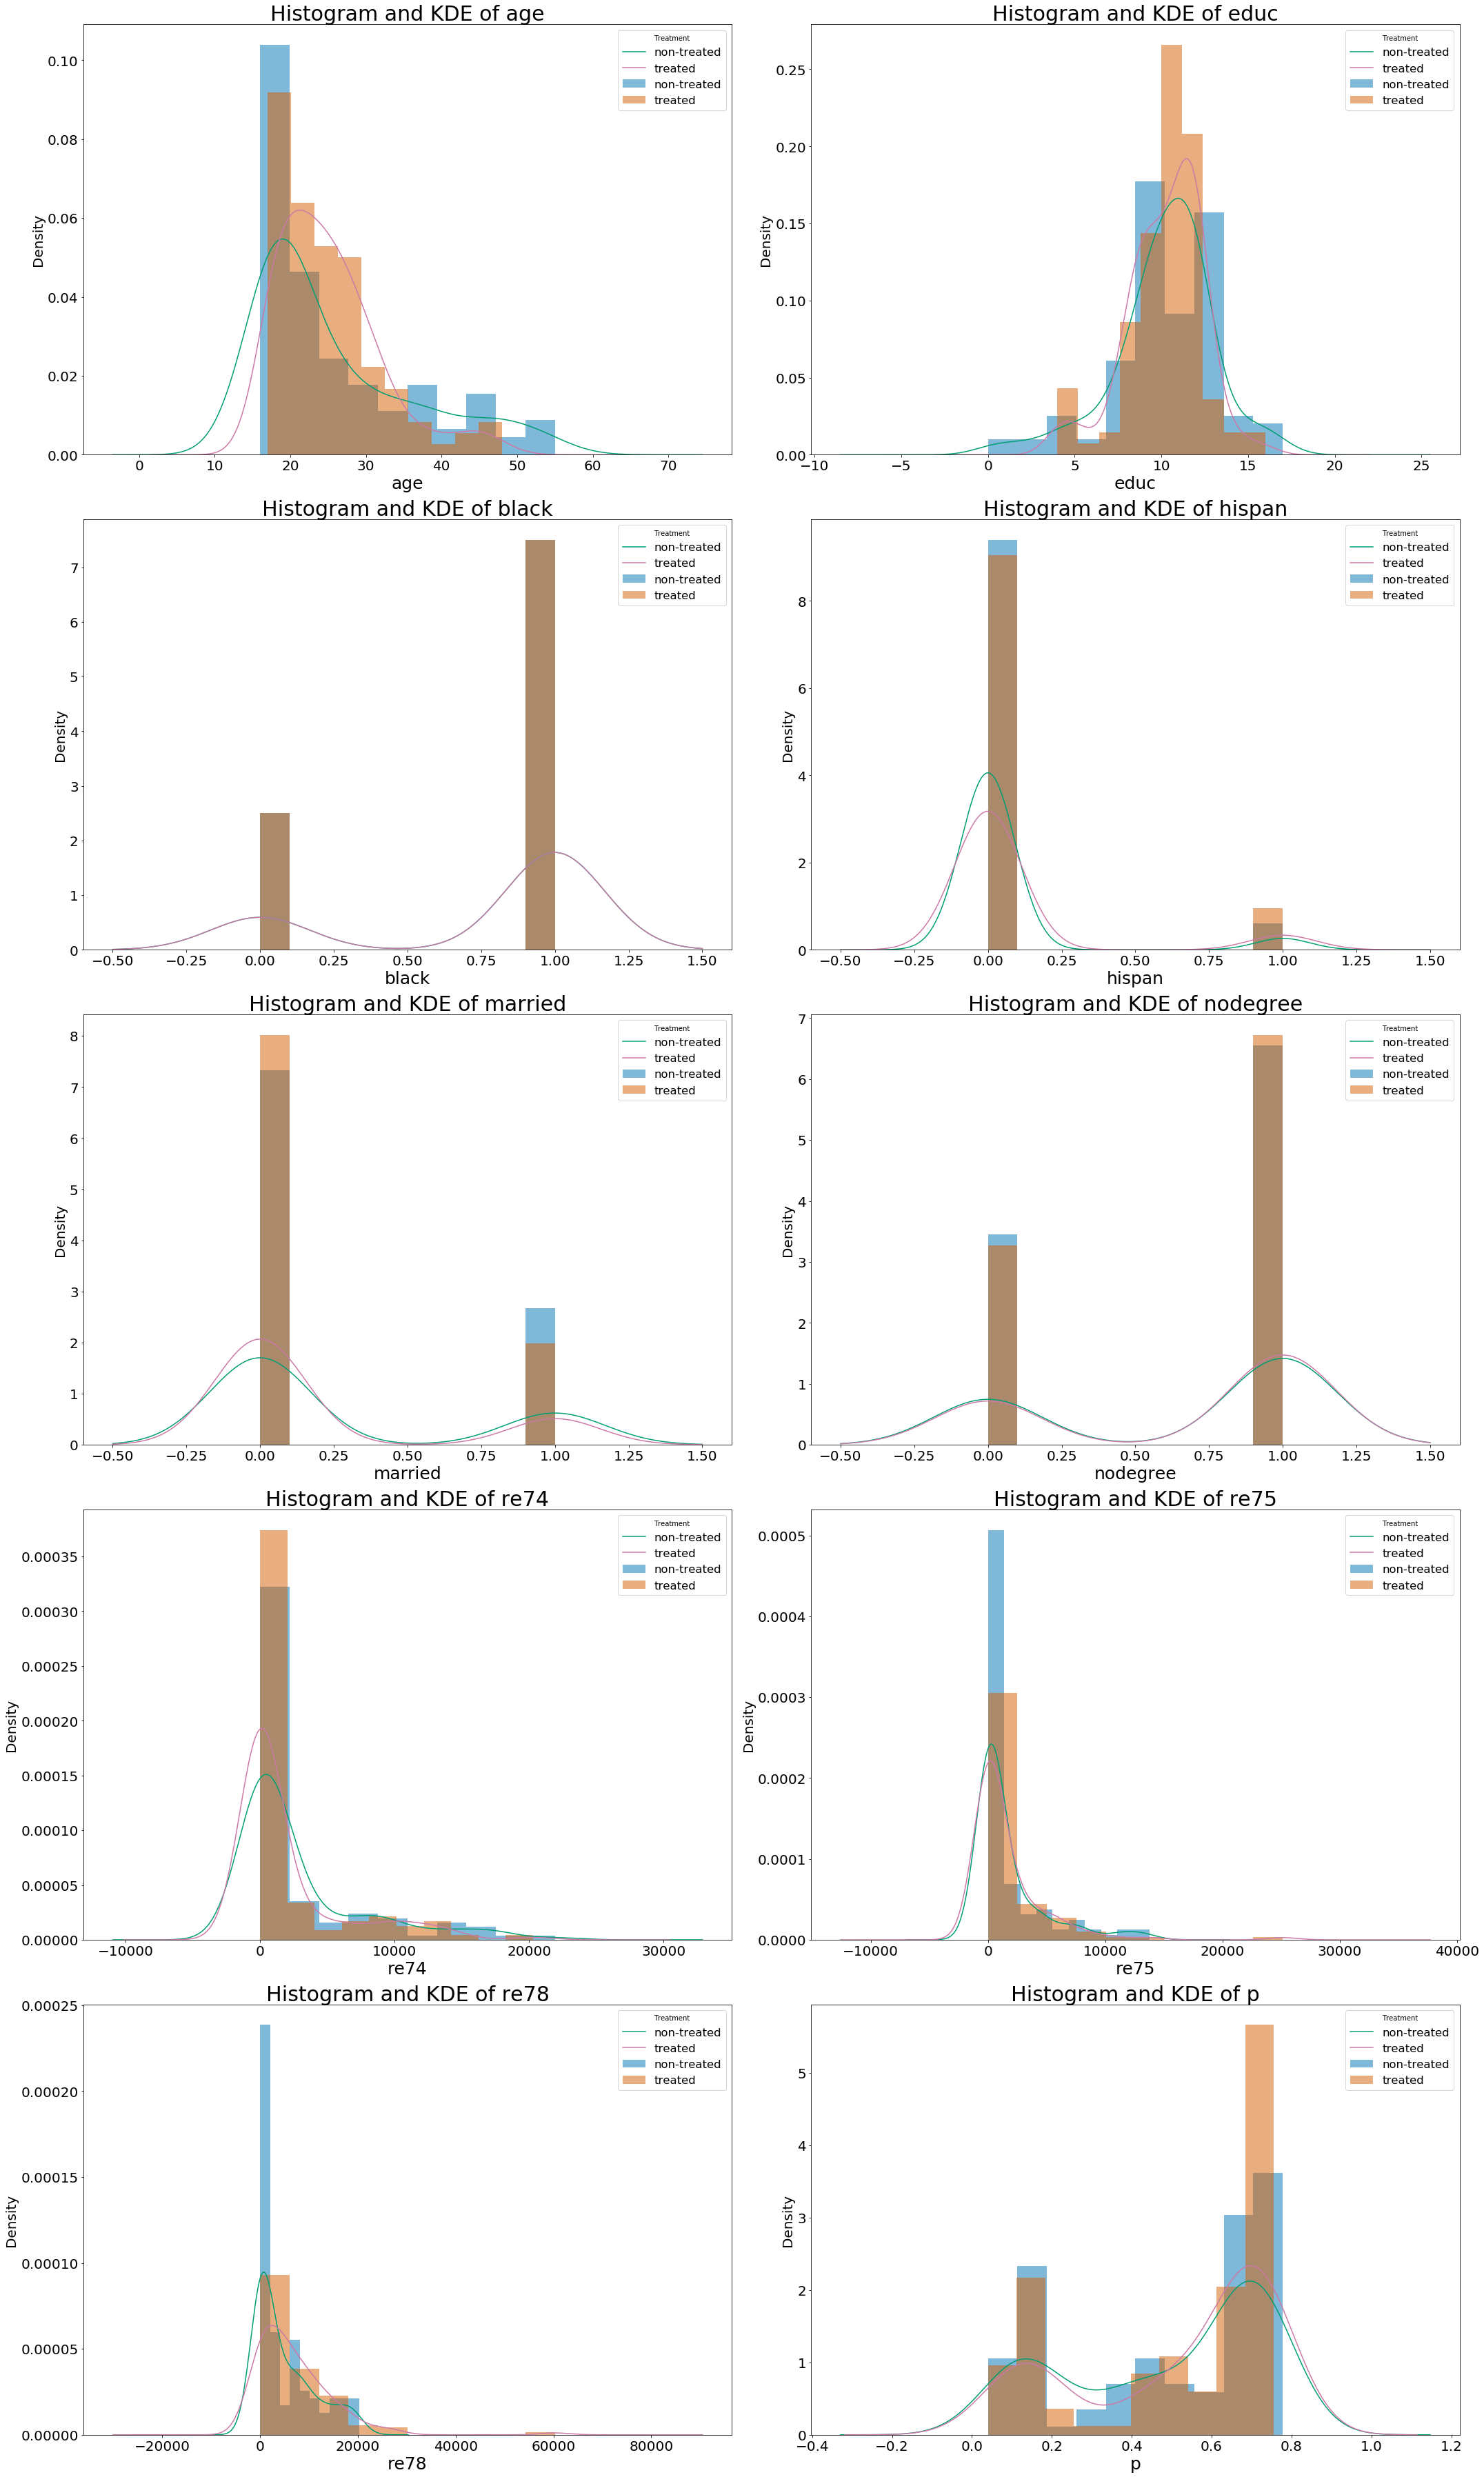

In [33]:
density_hist_data(data_matched_2, 2, 5)

<span style="color:#0047b3;">Now when we compare `re78` in the treated group and the non-treated group.

In [34]:
compare_feature(data_notreat['re78'], data_treat['re78'])

,non treated,treated
count,116.000000,116.000000
mean,4977.390633,6967.175924
std,6007.642036,8148.733900
min,0.000000,0.000000
25%,0.000000,888.141575
50%,2195.163000,4976.095500
75%,7988.959250,10011.045500
max,20243.380000,60307.930000


In [35]:
print("Improvement of "
      +str(round((data_treat.re78.mean()-data_notreat.re78.mean())/data_notreat.re78.mean()*100,2))
      +" % for the mean")

print("Improvement of "
      +str(round((data_treat.re78.median()-data_notreat.re78.median())/data_notreat.re78.median()*100,3))
      +" % for median")

Improvement of 39.98 % for the mean
Improvement of 126.685 % for median


<span style="color:#0047b3;">Now we can see improvement: a lot of people found a job after the treatment (median).<br><br>
Also, the mean has an improvement of 21%.</span>

#### 1.6 A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


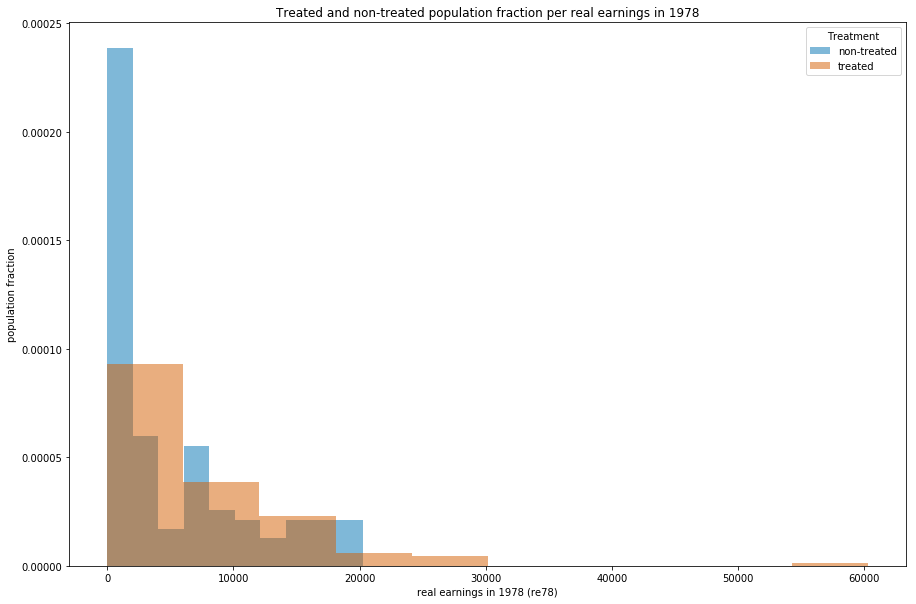

In [36]:
ax = data_matched_2.groupby('treat')['re78'].plot.hist(figsize=(15,10), legend=True, normed=True, alpha=0.5)
ax[0].set_title('Treated and non-treated population fraction per real earnings in 1978')
ax[0].set_ylabel('population fraction')
ax[0].set_xlabel('real earnings in 1978 (re78)')
ax[0].legend(title='Treatment', labels=['non-treated', 'treated'], loc='upper right');

In [37]:
#compare_re78(data_notreat, data_treat)
compare_feature(data_notreat.loc[data['treat'] == 0]['re78'],data_treat.loc[data['treat'] == 1]['re78'])

,non treated,treated
count,116.000000,116.000000
mean,4977.390633,6967.175924
std,6007.642036,8148.733900
min,0.000000,0.000000
25%,0.000000,888.141575
50%,2195.163000,4976.095500
75%,7988.959250,10011.045500
max,20243.380000,60307.930000


<span style="color:#0047b3;">**Conclusion** <br>Now we can say that the salary improves after the treatment in both groups that were pick under the assumptions of our balancing.
The treated group also get a higher mean.
    

___

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency-inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.


In [38]:
import itertools
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### <span style="color:#0047b3;">1. TF-IDF

In [39]:
newgroup = fetch_20newsgroups()

In [40]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newgroup.data) # vectorize

In [41]:
print('Number of articles:', len(newgroup.data))
print('Shape:', vectors.shape)

Number of articles: 11314
Shape: (11314, 130107)


<span style="color:#0047b3;">There are 11314 articles in total: we split them into three sets, the training set (80% of the articles) the testing set (10% of the articles) and the validation set (remaining 10% of the articles, automatically cut in the GridSearchCV function):

In [42]:
X_train, X_test, y_train, y_test = train_test_split(vectors, newgroup.target, test_size=0.1, random_state=1)

In [43]:
print('Number of training+validating samples:', X_train.shape[0])
print('Number of test samples:', X_test.shape[0])

Number of training+validating samples: 10182
Number of test samples: 1132


### <span style="color:#0047b3;">2. Random forest training

#### <span style="color:#0047b3;">Parameters tuning using grid search

<span style="color:#0047b3;">We now use grid search in order to find the best parameter, together with cross-validation :

In [35]:
param_grid = {'n_estimators': np.arange(650, 800, 50),
              'max_depth': np.arange(90, 120, 10)}

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=3, verbose=20)
param = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed: 68.7min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 77.9min finished


In [37]:
grid_search.best_params_

{'max_depth': 110, 'n_estimators': 750}

In [39]:
grid_search.best_score_

0.83981536043999216

In [52]:
grid_search.score(X_test, y_test)

0.86925795053003529

<span style="color:#0047b3;">Here is a sample of the results we get with different parameters :

In [51]:
ddf = pd.DataFrame({'Max_depth' : [90,110], 'N_estimator' : [650,750], 'Test score' : ['86.8%', '86.9%']})
#ddf.reset_index()
ddf

,Max_depth,N_estimator,Test score
0,90,650,86.8%
1,110,750,86.9%


<span style="color:#0047b3;">We will not explore more parameters with grid search, because it requires a lot of computing power!
However, it seems the greater the parameter, the more efficient is the model until there.

<span style="color:#0047b3;">Now, we use the best hyperparameter found to build our classifier:

In [45]:
# Copy your hyperparameters found by grid search here
max_depth = 110
n_estimators = 750

In [46]:
clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
clf.score(X_test, y_test)

0.87897526501766787

<span style="color:#0047b3;">**Results**

#### <span style="color:#0047b3;">Confusion matrix

In [48]:
cm = confusion_matrix(clf.predict(X_test),y_test)

Normalized confusion matrix


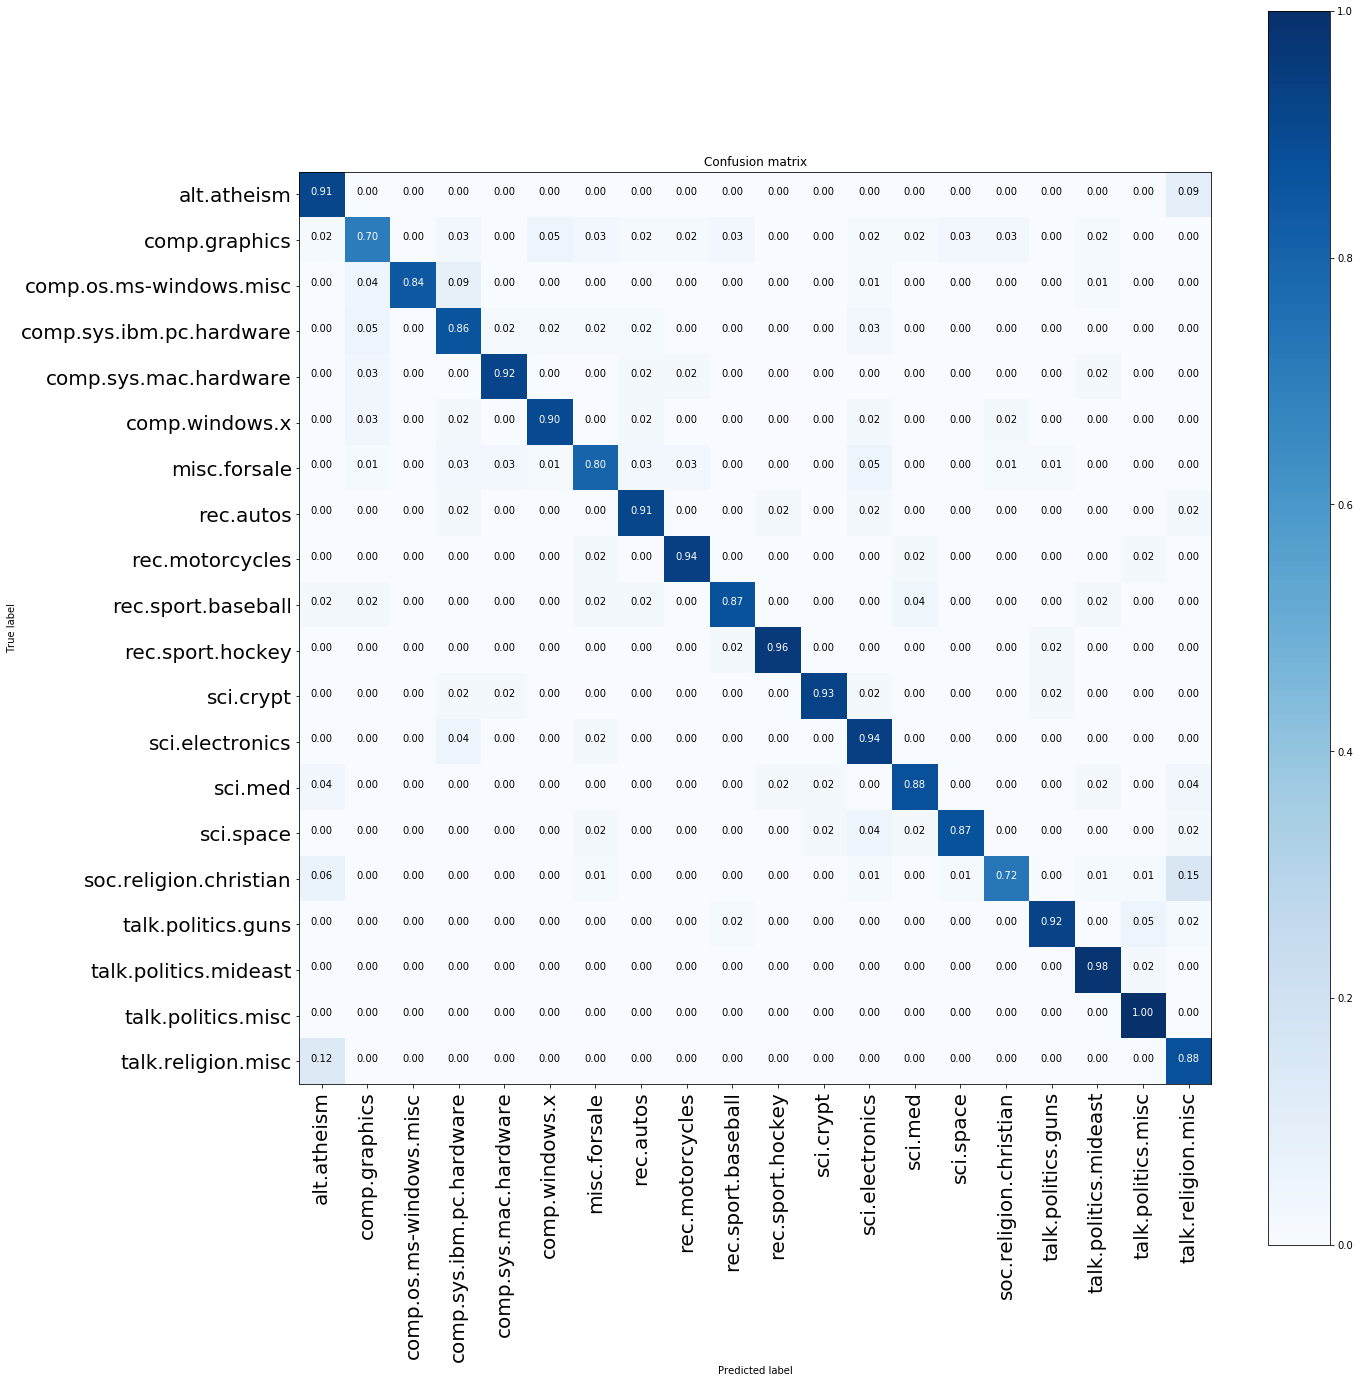

In [49]:
# from sklearn sample
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,size=20)
    plt.yticks(tick_marks, classes,size=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,newgroup.target_names,True)

<span style="color:#0047b3;">We can see that our classifier work pretty well, more than 0.71 in each category and lot of more than 0.95! for a final score of : 0.87

#### <span style="color:#0047b3;">Model assessment on test set<br>
<span style="color:#0047b3;">Let's have a look at the 10 most important features (higher value means higher importance)

In [50]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][0:10]

In [51]:
# Simply add the indices and importances in a dataframe to print them properly
df = pd.DataFrame(np.stack(((indices), (importances[indices])), axis=-1), columns=['findex', 'fimp'])
df.findex = df.findex.astype(int)
df.columns = ['Feature index', 'Feature importance']
df.index = range(1,len(df)+1)
df.columns.rename('Rank', inplace=True)
df

Rank,Feature index,Feature importance
1,48421,0.004658
2,124434,0.004429
3,104409,0.004147
4,33301,0.004122
5,37780,0.003615
6,40446,0.003231
7,109061,0.003065
8,89362,0.002878
9,63638,0.002787
10,59626,0.002735


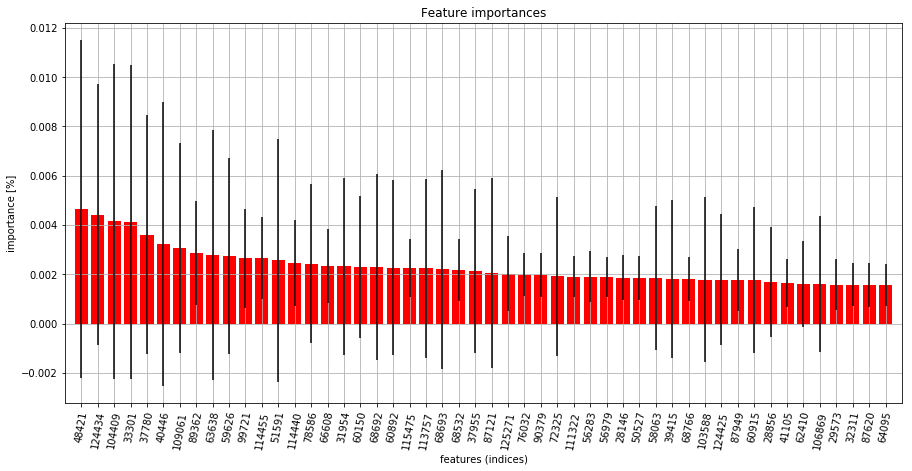

In [52]:
nb_feat = 50
indices = np.argsort(importances)[::-1][0:nb_feat]

# Plot the feature importances of the random forest
plt.figure(figsize=(15,7))
plt.bar(range(0,nb_feat), importances[indices],color="r", yerr=std[indices], align="center")
plt.title('Feature importances')
plt.xlabel('features (indices)')
plt.ylabel('importance [%]') 
plt.xticks(range(0,nb_feat), indices, rotation=80)
plt.xlim([-1, nb_feat])
plt.grid(True)
plt.show()

<span style="color:#0047b3;">**Features**<br>
The top-10 features together seem to represent less than 4% of the features. This implies that our model really needs a lot of features (most of them in fact) to reach its performance. It represents well the complexity of this task ; a few features is not enough to classify correctly articles in the right category.
This is also show by the height variance bewtenn each tree(black line).
